# Replication of results for optimal number of subnetworks

In [111]:
import functools
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator

In [112]:
%load_ext tensorboard
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [113]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [118]:
# Load the datasets - this directory contain folders of the model at each epoch
ROOT_PATH = 'gdrive/My Drive/KTH/MNIST_models/MNIST_NN/WRN28-2/'
# All model paths:
model_paths = [
  'M1/summaries/events.out.tfevents.1637871015.deeplearning-1-vm.9861.0.v2',
  'M2/summaries/events.out.tfevents.1637674717.deeplearning-1-vm.26676.0.v2',
  'M3/summaries/events.out.tfevents.1637590374.deeplearning-1-vm.27110.0.v2',
  'M4/summaries/events.out.tfevents.1637741894.deeplearning-1-vm.20526.0.v2',
  'M5/summaries/events.out.tfevents.1637828638.deeplearning-1-vm.19571.0.v2',
  'M6/summaries/events.out.tfevents.1637913700.deeplearning-1-vm.32648.0.v2',
  'M10/summaries/events.out.tfevents.1638560063.deeplearning-1-vm.12253.0.v2'
]
MODEL_PATH = ROOT_PATH+'M1/summaries/events.out.tfevents.1637871015.deeplearning-1-vm.9861.0.v2'
model_folders = os.listdir(ROOT_PATH)
print(len(model_folders))

7


In [119]:
!tensorboard --inspect --event_file=MODEL_PATH

2021-12-04 17:15:56.899438: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Processing event files... (this can take a few minutes)

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 289, in _run_serve_subcommand
    efi.inspect(flags.logdir, event_file, flags.tag)
  File "/u

In [120]:
from tensorboard.backend.event_processing import event_accumulator
ea = event_accumulator.EventAccumulator(MODEL_PATH)
ea.Reload()
ea.Tags()

{'audio': [],
 'distributions': [],
 'graph': False,
 'histograms': [],
 'images': [],
 'meta_graph': False,
 'run_metadata': [],
 'scalars': [],
 'tensors': ['train/negative_log_likelihood',
  'train/accuracy',
  'train/loss',
  'train/ece',
  'test/negative_log_likelihood',
  'test/accuracy',
  'test/ece',
  'test/diversity/disagreement',
  'test/diversity/average_kl',
  'test/diversity/cosine_similarity',
  'test/nll_member_0',
  'test/accuracy_member_0',
  'test/ms_per_example',
  'test/nll_mean_corrupted',
  'test/kl_mean_corrupted',
  'test/elbo_mean_corrupted',
  'test/accuracy_mean_corrupted',
  'test/ece_mean_corrupted',
  'test/member_acc_mean_corrupted',
  'test/member_ece_mean_corrupted',
  'test/nll_mean_1',
  'test/kl_mean_1',
  'test/elbo_mean_1',
  'test/accuracy_mean_1',
  'test/ece_mean_1',
  'test/nll_median_1',
  'test/kl_median_1',
  'test/elbo_median_1',
  'test/accuracy_median_1',
  'test/ece_median_1',
  'test/member_acc_mean_1',
  'test/member_ece_mean_1']}

In [121]:

ensemble_accuracies = []
ensemble_nll = []
member_accuracies = []
member_nlls = []
ensemble_members = [1,2,3,4,5,6,10]
all_member_accuracies = []
for i in range(7):
  model_path = model_paths[i] 
  a = summary_iterator(ROOT_PATH + model_path)

  TAG_NAME = "test/accuracy"
  NLL_NAME = 'test/negative_log_likelihood'
  MEMBER_TAG_NAMES = []
  MEMBER_NLL_NAMES = []
  for j in range(ensemble_members[i]): # collect the data for each of the ensemble members in the current model
    MEMBER_TAG_NAMES.append('test/accuracy_member_'+str(j))
    MEMBER_NLL_NAMES.append('test/nll_member_'+str(j))

  acc_list = []
  nll_list = []
  member_acc = {}
  member_nll = {}
  for e in a:
      for v in e.summary.value:
          if v.tag == TAG_NAME:
              value = tf.make_ndarray(v.tensor)
              acc_list.append(value)
          elif v.tag == NLL_NAME:
              value = tf.make_ndarray(v.tensor)
              nll_list.append(value)
          elif v.tag in MEMBER_TAG_NAMES:
            value = tf.make_ndarray(v.tensor)
            if not v.tag in member_acc:
              member_acc[v.tag] = []
            member_acc[v.tag].append(value)
          elif v.tag in MEMBER_NLL_NAMES:
            value = tf.make_ndarray(v.tensor)
            if not v.tag in member_nll:
              member_nll[v.tag] = []
            member_nll[v.tag].append(value)

  ensemble_accuracies.append(np.max(np.array(acc_list)))
  ensemble_nll.append(np.min(np.array(nll_list)))
  member_accuracies.append(member_acc)
  member_nlls.append(member_nll)
  print('ensemble accs: ', ensemble_accuracies)

ensemble accs:  [0.9966363]
ensemble accs:  [0.9966363, 0.99641925]
ensemble accs:  [0.9966363, 0.99641925, 0.9965278]
ensemble accs:  [0.9966363, 0.99641925, 0.9965278, 0.9967448]
ensemble accs:  [0.9966363, 0.99641925, 0.9965278, 0.9967448, 0.9967448]
ensemble accs:  [0.9966363, 0.99641925, 0.9965278, 0.9967448, 0.9967448, 0.9965278]
ensemble accs:  [0.9966363, 0.99641925, 0.9965278, 0.9967448, 0.9967448, 0.9965278, 0.99327254]


In [122]:
# parse the member accuracies and nlls
# for each of the different network architectures
accs = []
nlls = []
for i in range(len(member_accuracies)):
  current_accuracies = member_accuracies[i]
  current_nll = member_nlls[i]
  accs_curr = []
  nlls_curr = [] 
  for key, value in current_accuracies.items():
    # member_accuracies[i][key] = value[-1]
    accs_curr.append(np.max(np.array(value)))
  for key, value in current_nll.items():
    # member_nlls[i][key] = value[-1]
    nlls_curr.append(np.min(np.array(value)))
  accs.append(accs_curr)
  nlls.append(nlls_curr)
print(accs)
print(nlls)


[[0.9966363], [0.9963108, 0.9958767], [0.99641925, 0.99620223, 0.99576825], [0.9953342, 0.99641925, 0.99620223, 0.9966363], [0.99620223, 0.9954427, 0.99609375, 0.9963108, 0.9954427], [0.9954427, 0.9953342, 0.9953342, 0.99522567, 0.9951172, 0.9954427], [0.98546004, 0.95844185, 0.96202254, 0.97927517, 0.9864366, 0.98947483, 0.9812283, 0.8314887, 0.9880642, 0.8567708]]
[[0.012312468], [0.013654267, 0.0153304525], [0.013152674, 0.01772215, 0.016845293], [0.017751029, 0.015294882, 0.014885942, 0.015912205], [0.016215593, 0.017832404, 0.016199417, 0.016243601, 0.018173292], [0.018869512, 0.01783072, 0.017213091, 0.01846847, 0.0184579, 0.0196161], [0.05315123, 0.18841498, 0.16358347, 0.08816663, 0.05191607, 0.051096674, 0.07873843, 0.49105707, 0.06097814, 0.44006905]]


In [123]:
# compute means and stds of each number of members
acc_means = []
acc_std = []
nll_means = []
nll_std = []
for i in range(7):
  acc_means.append(np.mean(np.array(accs[i])))
  acc_std.append(np.std(np.array(accs[i])))
  nll_means.append(np.mean(np.array(nlls[i])))
  nll_std.append(np.std(np.array(nlls[i])))


In [139]:
def plot_results(num_members, ensemble, member_means, member_stds, title, include_var=True):
    plt.plot(num_members, member_means, label='Members')
    plt.plot(num_members, ensemble, label="Ensemble")
    if include_var:
        plt.errorbar(num_members, member_means, member_stds, linestyle='None', marker='^', label='variance')
    plt.title(title)
    plt.xlabel('M')
    plt.legend()
    plt.show()
    plt.savefig(ROOT_PATH + 'acc_comparison_'+title+'.png')

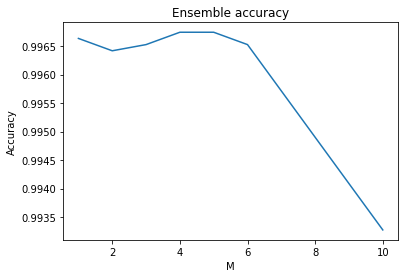

ensemble accs: [0.9966363, 0.99641925, 0.9965278, 0.9967448, 0.9967448, 0.9965278, 0.99327254]
ensemble nlls:  [0.012312468, 0.013079784, 0.012517553, 0.012618124, 0.012679949, 0.014126082, 0.3663068]
member accs: [0.9966363, 0.99609375, 0.99612993, 0.996148, 0.9958984, 0.9953161, 0.95186627]
member nlls:  [0.012312468, 0.01449236, 0.015906706, 0.015961014, 0.016932862, 0.018409299, 0.16671719]


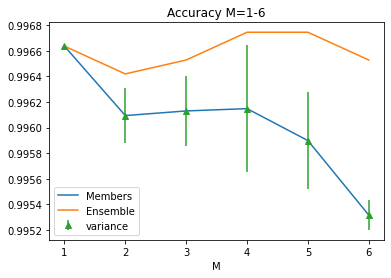

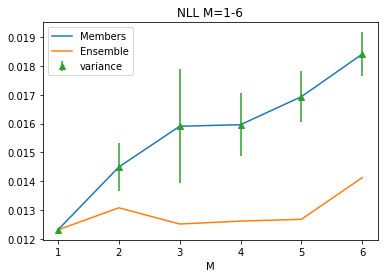

<Figure size 432x288 with 0 Axes>

In [142]:
num_members = [1, 2, 3, 4, 5, 6, 10]
plt.plot(num_members, ensemble_accuracies, label="Ensemble")
plt.title('Ensemble accuracy')
plt.xlabel('M')
plt.ylabel('Accuracy')
plt.show()
plt.savefig(ROOT_PATH + 'ensemble_accuracy_M1_to_M10.png')
print('ensemble accs:', ensemble_accuracies)
print('ensemble nlls: ', ensemble_nll)
print('member accs:', acc_means)
print('member nlls: ', nll_means)
plot_results(num_members[:6], ensemble_accuracies[:6], acc_means[:6], acc_std[:6], 'Accuracy M=1-6')
plot_results(num_members[:6], ensemble_nll[:6], nll_means[:6], nll_std[:6], 'NLL M=1-6')

# Disagreement of subnetworks

KL:  0.011273645
Disagreement:  0.0033998839
Cosine similarity:  [array(nan, dtype=float32), array(0.99787945, dtype=float32), array(0.9975345, dtype=float32), array(0.9975345, dtype=float32), array(0.99725753, dtype=float32), array(0.99689746, dtype=float32), array(0.6345937, dtype=float32)]


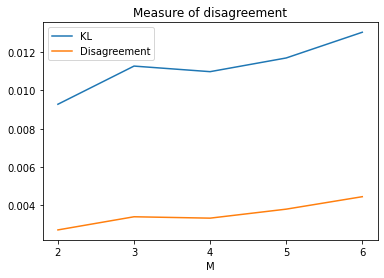

<Figure size 432x288 with 0 Axes>

In [137]:
# Get the disagreement between the subnetworks

d_kl = []
d_disagreement = []
d_cosine_sim = []
ensemble_members = ['1','2','3','4','5','6', '10']
# for M = 10 the disagreement is super high! must be wrong..

for i in range(7):
  model_path = model_paths[i] 
  a = summary_iterator(ROOT_PATH + model_path)

  DIS = "test/diversity/disagreement"
  KL = 'test/diversity/average_kl'
  COS = 'test/diversity/cosine_similarity'

  dis_list = []
  kl_list = []
  cos_list = []
  for e in a:
      for v in e.summary.value:
          if v.tag == DIS:
              value = tf.make_ndarray(v.tensor)
              dis_list.append(value)
          elif v.tag == KL:
              value = tf.make_ndarray(v.tensor)
              kl_list.append(value)
          elif v.tag == COS:
            value = tf.make_ndarray(v.tensor)
            cos_list.append(value)
  
  d_kl.append(kl_list[-1])
  d_disagreement.append(dis_list[-1])
  d_cosine_sim.append(cos_list[-1])

print('KL: ', d_kl[2])
print('Disagreement: ', d_disagreement[2])
print('Cosine similarity: ', d_cosine_sim)

plt.plot(ensemble_members[1:6], d_kl[1:6], label="KL")
plt.plot(ensemble_members[1:6], d_disagreement[1:6], label="Disagreement")
# plt.plot(d_cosine_sim, label="Cosine similarity")
plt.title('Measure of disagreement')
plt.xlabel('M')
plt.legend()
plt.show()
plt.savefig(ROOT_PATH + 'disagreement_and_KL_M1_toM6.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>